In [2]:
import os
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd

# Homework 1: Bayesian Cognitive and Rational Speech Act models

This homework assignment is to be completed in groups. It is due on November 27, 2025 (midnight). Please upload *all files you created or modified* to the homework folder of your group in studIP.

Group number:

Names:

*General note: It is permitted to use AI tools for coding. Please refer to the uploaded manual `AI_Tools_Guidelines` for recommended ways how to use AI to advance your studies in a way that supports your learning. That means that you should not be satisfied if an AI tool hands you a working version of your code, but that you should put in effort to understand how exactly the problem is solved. Another note of caution: What might work for large programming languages like Python, does not necessarily work for Stan. Check your code carefully and do NOT blindly trust AI.*

## Introduction
During the past weeks, you have learned how Bayesian inference works and how it can be used in Bayesian cognitive models. You also learned about a specific type of Bayesian models that can be used to model pragmatic language understanding and production, the Rational Speech Act models. The goal of this homework assignment is for you to learn how to implement Bayesian models in Stan and, specifically, how to implement RSA models in Stan. A special focus will be on the different use cases and evaluation methods of RSA models.

## 1) Stan modeling (8 points)

1.1) In the file `simple_model.stan`, you will find a simple Stan model. Describe its implementation, relating it to the knowledge you gained about the conventions for coding models in Stan. (4 points)

- The data block defines the observed data: we have N trials, and for each trial we know the semantic similarity, the phonological similarity, and the response time.
- In the transformed data block, the response times are log-transformed, so the model works on log_rt. This makes the normality assumption more reasonable, because raw response times are positive and often skewed.
- In the parameters block, the model estimates:
    - alpha (intercept),
    - beta_sem (effect of semantic similarity),
    - beta_phon (effect of phonological similarity),
    - sigma_rt (residual standard deviation, constrained to be positive).
    - Each of these parameters has a weakly informative normal prior.
- In the model block, each log_rt[i] is assumed to follow a normal distribution with mean alpha + beta_sem * semantic_similarity[i] + beta_phon * phonological_similarity[i] and standard deviation sigma_rt. So the two similarity measures linearly predict log response time.
- In the generated quantities block:
    - log_likelihood[i] stores the pointwise log density for each trial,
    - log_rt_ppd[i] stores posterior-predictive draws on the log scale,
    - rt_ppd[i] exponentiates those draws back to the original time scale, giving predicted response times for posterior predictive checks.

Essentially, it’s a Bayesian linear regression model that predicts how fast someone responds based on how semantically and phonologically related the word and context are.

1.2) You will notice that the model does not compile. Fix the problems and explain what you did. (4 points)

    The model compiles:)

## 2) Bayesian cognitive models (10 points)
Think of a use case for `simple_model.stan` in the scope of Bayesian cognitive modeling. Describe the model while answering the following questions:

2.1) What cognitive capacity can be explained by this model? (2 points)

- The model describes lexical access in tasks like visual lexical decision or picture naming: how quickly a person can retrieve the correct word form when given semantic and phonological cues from a context.
- The predictors capture two psychologically meaningful influences:
    - semantic priming: effect of meaning similarity,
    - phonological priming: effect of sound similarity,
- and the strength of these influences changes the observed response times.

2.2) What is the purpose and function of this model? (3 points)

- The model explains how semantic and phonological similarity jointly produce the distribution of RTs we observe.
- By fitting this Bayesian regression, we can:
    - estimate how much semantic and phonological similarity speed up or slow down retrieval,
    - quantify priming effects at the level of participants or conditions,
    - generate posterior predictive RT distributions for new items or contexts,
    - compare hypotheses (e.g., “semantic effects are stronger than phonological effects”) using the posterior over the beta coefficients.

2.3) At which level of analysis does it model this cognitive capacity and why? (3 points)

- The Stan model is a computational model in Marr’s framework. It specifies what mapping the cognitive system implements: given inputs (semantic similarity and phonological similarity), it defines a probability distribution over response times.
- The code does not specify an algorithm or representation format for lexical access (no activation dynamics, no specific retrieval steps, no architecture), so it is not an algorithmic-level model. And it does not mention neural structures or hardware, so it is not an implementational-level model either. It remains at the abstract, probabilistic computational-level description of the capacity “map semantic/phonological similarity to response-time distributions.”


Overall coherence gives another 2 points.

## 3) RSA modeling (82 points)
The purpose of the following model is to explain the use of overinformative referring expressions in pragmatic communication. In referential communication, the speaker’s task is to produce a referring expression that allows a listener to identify the target in the context. Consider the context below, where the target is the small blue pin. A referring expression including a size adjective (the small pin) is strictly speaking sufficient for uniquely establishing reference to the target, yet speakers often “overmodify” with color, producing referring expressions like the small blue pin. This overmodification phenomenon is what the model is intended to capture.

<img src="img/size-sufficient.png" width="400"/>

### 3.1) Vanilla RSA (20 points)
In the file `vanilla_rsa.stan`, you find an RSA model of the production of referring expressions, based on the vanilla RSA model of Frank & Goodman (2012) that we discussed in class.

3.1.1) Provide informative comments in the file `vanilla_rsa.stan`. (4 points)

3.1.2) You will notice that the parameters and model blocks are empty. Why is that? Go through the following code and inspect the model's behavior. Look at the stan variables that are included in the fitted model. (3 points)

    There are no parameters and no defined model, as we are not doing Bayesian sampling. We are not trying to estimate any values but rather arrive at our results deterministically.

In [4]:
# compile model
stan_file = os.path.join('stan', 'vanilla_rsa.stan')
rsa_model = CmdStanModel(stan_file=stan_file)

In [5]:
# define input data
states = ["big_blue", "big_red", "small_blue"]
short_utterances = [
    "big", "small", "blue", "red"
]
utterances = [
    "big", "small", "blue", "red", "big_red", "big_blue", "small_blue"
]
n_states = len(states)
n_utterances   = len(utterances)

# build meaning_matrix[u, s]
meaning_matrix = np.zeros((n_utterances, n_states), dtype=int)
for u, utterance in enumerate(utterances):
    for s, state in enumerate(states):
        # literal meaning maps to true iff the utterance string appears in the state string
        # Stan cannot handle booleans, so we need to work with integers here
        meaning_matrix[u, s] = int(utterance in state)

# parameters - change them here
alpha = 1.0
cost_weight = 1.0

# cost function
cost_dict = {
    "big": 0.0,
    "small": 0.0,
    "blue": 0.0,
    "red": 0.0,
}
default_cost = np.array([cost_dict[utterance] for utterance in short_utterances])

# new cost functions
def cost_by_letters(utterance, per_letter=0.1):
    letters = sum(1 for ch in utterance if ch.isalpha())
    return letters * per_letter

def cost_by_underscores(utterance, per_underscore=.0):
    return utterance.count('_') * per_underscore

cost = np.array([cost_by_underscores(utterance) for utterance in utterances])

# prepare Stan data as dictionary
stan_data = {
    "S": n_states,
    "U": n_utterances,
    "meaning_matrix": meaning_matrix.tolist(), # Stan cannot handle numpy arrays       
    "cost": cost.tolist(),                     # or dictionaries
    "alpha": alpha,
    "cost_weight": cost_weight
}

fit = rsa_model.sample(stan_data, show_console=True, chains=1, iter_warmup=0, adapt_engaged=False, iter_sampling=1)

18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1
Chain [1] num_warmup = 0
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 0
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\Hannes\AppData\Local\Temp\tmpfz_r_e0l\hga44caq.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 9162
Chain [1] output
Chain [1] f

In [4]:

L0_draws = fit.stan_variable('L0')
S1_draws = fit.stan_variable('S1')

L0 = L0_draws[0]
S1 = S1_draws[0]

df_L0 = pd.DataFrame(L0, index=utterances, columns=states)
df_S1 = pd.DataFrame(S1, index=states, columns=utterances)

print("L0:")
print(df_L0.to_string(float_format="{:.2f}".format))
print("S1:")
print(df_S1.to_string(float_format="{:.2f}".format))

L0:
            big_blue  big_red  small_blue
big             0.50     0.50        0.00
small           0.00     0.00        1.00
blue            0.50     0.00        0.50
red             0.00     1.00        0.00
big_red         0.00     1.00        0.00
big_blue        1.00     0.00        0.00
small_blue      0.00     0.00        1.00
S1:
            big  small  blue  red  big_red  big_blue  small_blue
big_blue   0.25   0.00  0.25 0.00     0.00      0.50        0.00
big_red    0.20   0.00  0.00 0.40     0.40      0.00        0.00
small_blue 0.00   0.40  0.20 0.00     0.00      0.00        0.40


3.1.3) Are the outputs in line with what you would expect given your knowledge about pragmatic communication and overinformative referring expressions?
Add complex utterances to the model (i.e., utterance consisting of a size and color adjective) and inspect the output again. The meaning of a complex two-word utterance is defined with intuitive intersective semantics: $$\mathcal{L}(u_{\text{complex}}, o)=\mathcal{L}(u_{\text{size}},o)\times\mathcal{L}(u_{\text{color}},o)$$ (6 points)

    It makes sense, especially in S1 that the utility of the characteristic that is unique about a state (e.g. "red" in "big_red") is higher, as there is no ambiguity there.
    When adding a complex utterance where its consituence are found in the states but not in that combination, it shows NaN in L0 and then S1 is filled with NaN everywhere. 
    If we add the three complex utterances that fully describe the states, we can observe that in S1, the utility of non-complex utterances is equal to or lower than the complex utterances. This makes intuitive sense if there is no cost of length, as it is more precise in referring to a state.

3.1.4) Play around with the rationality and cost weight parameters. How do they affect the model output? (4 points)

    The lower rationality, the more uniform are the values distributed. 
    The higher the costs, the more non-complex statements are valued.

3.1.5) Adapt the utterance cost in a way that achieves a preference for overinformative referring expressions. (2 points)

    Add minus to "per_letter" or "per_underscore"
    I 
3.1.6) Adapt the utterance cost in a way that seems most natural to you. (1 point)

    per word cost

### 3.2) Relaxed semantics (20 points)
It seems that our intuitions do not align well with the model. Let's use continuous rather than boolean semantics to see whether this can solve our problem. In the following, you need to adapt the RSA model and input data in a way that implements continuous semantics. The only change will be that the lexicon, or meaning matrix, should return real values instead of true or false: $$\mathcal{L}(u,o)\in [0,1] \subset \mathbb{R}$$
This approach captures the intuition that an object is not unambiguously big or blue, but rather that objects can count as big or blue to varying degrees.

3.2.1) Build a meaning matrix that captures the relaxed semantics with two new parameters size_semantics $x_\text{size}$ and color_semantics $x_\text{color}$. When an object $o$ is in the extension of a size adjective under the Boolean semantics defined above, take $\mathcal{L}(u,o)=x_\text{size}$, else $\mathcal{L}(u,o)=1-x_\text{size}$. The semantics are defined analogously for color. (6 points)
3.2.2) Run the model with alpha = 30, size_semantics = 0.8 and color_semantics = 0.99. Inspect the model outputs. (4 points)
3.2.3) Visualize the results of varying values for size_semantics and color_semantics, pit them against each other and interpret them. (6 points)
3.2.4) Van Gompel et al. (2019) found that speakers use overinformative referring expressions in about 80% of the trials that look like the one above, where size is sufficient to mention. What about contexts where color is sufficient to mention? Construct a context where color is sufficient to mention and interpret the output. (4 points)

In [6]:
# compile model
stan_file = os.path.join('stan', 'vanilla_rsa_relaxed_semantics.stan')
rsa_model = CmdStanModel(stan_file=stan_file)

In [7]:
# This is the code for exercise 3.2, adapted from the code for exercise 3.1.

# new parameters
x_size = 0.8 
x_color = 0.99

# define input data
states = ["big_blue", "big_red", "small_blue"]
utterances = [
    "big", "small", "blue", "red"
]
n_states = len(states)
n_utterances   = len(utterances)

# introduce size/color categorization
size_utterances  = ["big", "small"]
color_utterances = ["blue", "red"]

# build meaning_matrix[u, s]
meaning_matrix = np.zeros((n_utterances, n_states))
for u, utterance in enumerate(utterances):
    for s, state in enumerate(states):
        # check if object is in the extension of an adjective under Boolean semantics
        extension = utterance in state
        # check utterance category
        if utterance in size_utterances:
            x = x_size
        elif utterance in color_utterances:
            x = x_color
        # if object is in the extension of an adjective, take L(u,o) = x_size/color, else L(u,o) = 1 - x_size/color
        # e.g. "big" refers to big objects with probabiliy x and small objects with probability 1-x
        meaning_matrix[u, s] = x if extension else (1 - x)

# parameters - change them here
alpha = 30
cost_weight = 1.0

# cost function
cost_dict = {
    "big": 0.0,
    "small": 0.0,
    "blue": 0.0,
    "red": 0.0,
}
cost = np.array([cost_dict[utterance] for utterance in utterances])

# prepare Stan data as dictionary
stan_data = {
    "S": n_states,
    "U": n_utterances,
    "meaning_matrix": meaning_matrix.tolist(), # Stan cannot handle numpy arrays       
    "cost": cost.tolist(),                     # or dictionaries
    "alpha": alpha,
    "cost_weight": cost_weight,
    "x_size": x_size,
    "x_color": x_color
}

In [8]:
# Exercise 3.2.2: Run the model with alpha = 30, size_semantics = 0.8 and color_semantics = 0.99. Inspect the model outputs.

# We observe that color behaves like in non-relaxed semantics. For L0, P("big_red"|"red") = 1.0, reflecting that the color word
# practically determines that a pin of its color is chosen. We say "practically" because 0.99 is of course not 100%, but in
# practice we get a 1.0 probability. Again for L0, P("big_blue"|"blue") = 0.50. When the color word simply deterministically 
# decides that a pin of the stated color is to be chosen, the pins of the stated color are the only, equally viable candidates.
# S1 behaves analoguously. The size parameter is large enough to behave similarly as well.

# The number of chains should not make a difference with fixed parameters.
# For iter_warmup and iter_sampling, it is apparently best practice in a lot of cases to simply choose 500 because
# models will converge between 200 and 400. Going above 200 made absolutely no difference for us though, using a forward model.
fit = rsa_model.sample(stan_data, show_console=True, chains=1, iter_warmup=200, adapt_engaged=True, iter_sampling=200)
# fit.summary()

18:52:02 - cmdstanpy - INFO - Chain [1] start processing
18:52:02 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 200
Chain [1] num_warmup = 200
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\Hannes\AppData\Local\Temp\tmpfz_r_e0l\ck6t1zzj.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 73760
Chain [1] out

In [10]:
# Visualize results for exercise 3.2.2. 
# Exact same code as we used for exercise 3.1

L0_draws = fit.stan_variable('L0')
S1_draws = fit.stan_variable('S1')

L0 = L0_draws[0]
S1 = S1_draws[0]

df_L0 = pd.DataFrame(L0, index=utterances, columns=states)
df_S1 = pd.DataFrame(S1, index=states, columns=utterances)

print("L0:")
print(df_L0.to_string(float_format="{:.2f}".format))
print("S1:")
print(df_S1.to_string(float_format="{:.2f}".format))

L0:
       big_blue  big_red  small_blue
big        0.44     0.44        0.11
small      0.17     0.17        0.67
blue       0.50     0.01        0.50
red        0.01     0.98        0.01
S1:
            big  small  blue  red
big_blue   0.03   0.00  0.97 0.00
big_red    0.00   0.00  0.00 1.00
small_blue 0.00   1.00  0.00 0.00


18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.
18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.
18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.


18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.


18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.
18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.
18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.
18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.
18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.


18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:11 - cmdstanpy - INFO - CmdStan done processing.
18:52:11 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.


18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.


18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.


18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:12 - cmdstanpy - INFO - CmdStan done processing.
18:52:12 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.


18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.


18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.


18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.


18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.
18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.


18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.


18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.
18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.
18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.
18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.
18:52:13 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:13 - cmdstanpy - INFO - CmdStan done processing.
18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.


18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.


18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.
18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.


18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.


18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.
18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.
18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.
18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.


18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.
18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:14 - cmdstanpy - INFO - CmdStan done processing.


18:52:14 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.
18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.
18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.
18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:15 - cmdstanpy - INFO - CmdStan done processing.
18:52:15 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.
18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.
18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.


18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.
18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.


18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.
18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.
18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.


18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.
18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.
18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:16 - cmdstanpy - INFO - CmdStan done processing.


18:52:16 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.
18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.
18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.


18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.


18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.


18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.
18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.


18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.


18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.
18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.


18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.
18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:17 - cmdstanpy - INFO - CmdStan done processing.


18:52:17 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.
18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.
18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.
18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:18 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:18 - cmdstanpy - INFO - CmdStan done processing.


18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.


18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.
18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.
18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.
18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.
18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.


18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.


18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.
18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.
18:52:19 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/400 [00:00<?, ?it/s, (Warmup)]

18:52:19 - cmdstanpy - INFO - CmdStan done processing.


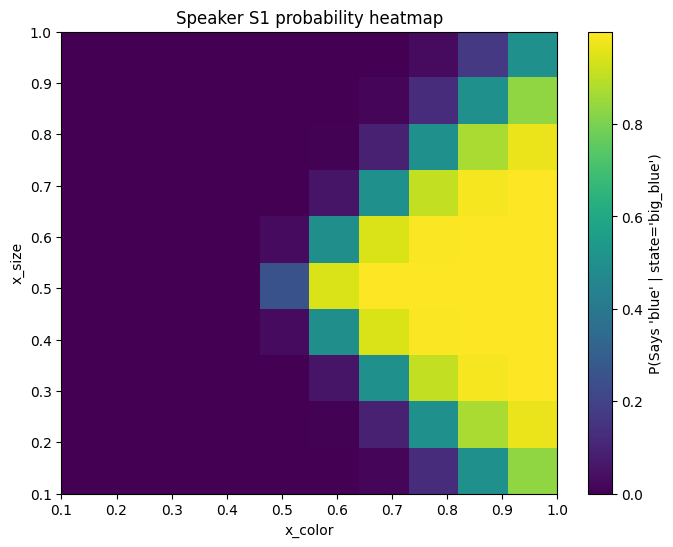

In [11]:
# Exercise 3.2.3
# The heat map generated by this cell shows P("blue"|"big_blue") for S1 given different size and color parameters.

import matplotlib.pyplot as plt

# This function was added (out of frustration) because the heat map just would not work at first.
# It is (as a beginner) not always intuitive how indexing works in Stan.
# The first versions of this cell generated heat maps that were only one color.
# Printing out the matrix showed that we read the indices in a confused manner. 
# This is possibly bloated, but it makes the code below more readable. 
def extract_matrix(samples, prefix, n_row, n_col):
    M = np.zeros((n_row, n_col))
    for r in range(1, n_row + 1):
        for c in range(1, n_col + 1):
            col = f"{prefix}[{r},{c}]"
            M[r - 1, c - 1] = samples[col].mean()
    return M

# We want to run the model for different values. This function will later be called from inside a loop to accomplish just that.
def run_rsa_for(x_size, x_color, rsa_model, base_stan_data):
    # The base data is copied to avoid potential side effects.
    stan_data = base_stan_data.copy()
    
    # This is familiar from the code for exercise 3.2.2.
    # The different values we want to compare will be plugged in here.
    stan_data["x_size"] = x_size
    stan_data["x_color"] = x_color

    # Same setup as in exercise 3.2.2
    fit = rsa_model.sample(
        stan_data,
        show_console=False,
        chains=1,            
        iter_warmup=200,
        iter_sampling=200,
        adapt_engaged=True
    )
    
    # Extract transformed parameters
    samples = fit.draws_pd()
    
    # Return mean values of L0 and S1.
    # Printing these out we get "L0[1,2]", "S1[2,3]", and so on and so forth.
    # This was helpful for troubleshooting, like the Stan manual suggests.
    L0_cols = [c for c in samples.columns if c.startswith("L0[")]
    S1_cols = [c for c in samples.columns if c.startswith("S1[")]

    U = stan_data["U"]
    S = stan_data["S"]

    L0_mean = extract_matrix(samples, "L0", U, S)   # U × S
    S1_mean = extract_matrix(samples, "S1", S, U)   # S × U

    return L0_mean, S1_mean

# We will try the values 0.1, 02..0.9, 1.0 for size and color.
# This simply seemed like the obvious choice, and it results in an interesting visualization.
x_size_vals = np.linspace(0.1, 1.0, 10)
x_color_vals = np.linspace(0.1, 1.0, 10)

# Here we store the results for visualization.
results = {}

# This is the loop announced above that runs the model for each value-pair.
for xs in x_size_vals:
    for xc in x_color_vals:

        # Rebuild meaning matrix
        # This is the same code as for exercise 3.2.2, except that it includes the variables xs and xc.
        # Otherwise we would not actually iterate over different value-pairs.
        meaning_matrix = np.zeros((n_utterances, n_states))
        for u, utterance in enumerate(utterances):
            for s, state in enumerate(states):
                extension = utterance in state
                if utterance in size_utterances:
                    x = xs
                elif utterance in color_utterances:
                    x = xc
                meaning_matrix[u, s] = x if extension else (1 - x)

        # Update stan_data
        stan_data["meaning_matrix"] = meaning_matrix.tolist()
        
        # Run RSA
        L0, S1 = run_rsa_for(xs, xc, rsa_model, stan_data)
        results[(xs, xc)] = S1

# We could plot any utterance.
utterance_index = utterances.index("blue")  
# We could plot any state
state_index = states.index("big_blue")      

# Standard heat map. 
# ChatGPT was used here via the following prompt: "Give me Python code to generate a heat map for 10 value pairs".
# Inserting our own variables, labels, and description resulted in the code below, which worked without further modifications.
# (As mentioned above, the heat map only contained one color at first, but that was because we had read in the matrix wrong.)
heatmap = np.zeros((len(x_size_vals), len(x_color_vals)))

for i, xs in enumerate(x_size_vals):
    for j, xc in enumerate(x_color_vals):
        heatmap[i, j] = results[(xs, xc)][state_index, utterance_index]

plt.figure(figsize=(8,6))
plt.imshow(heatmap, origin="lower", 
           extent=[min(x_color_vals), max(x_color_vals), 
                   min(x_size_vals), max(x_size_vals)],
           aspect="auto")
plt.colorbar(label=f"P(Says '{utterances[utterance_index]}' | state='{states[state_index]}')")
plt.xlabel("x_color")
plt.ylabel("x_size")
plt.title("Speaker S1 probability heatmap")
plt.show()

# The heat map shows what we expected it to. 
# Let's look at the example P("blue"|"big_blue") for S1. (Other utterances/states result in analoguous heat maps.*)
# The probability of saying "blue" increases with x_color. It decreases at the margins where x_size is very small or large.
# This is in line with what we discussed in 3.2.2. A more extreme color value places more importance on a color term, of course.
# If the color in "big_blue" is maximally important, S1 will always say "blue". When size is also (near) maximally important,
# P("blue") is reduced because the size term might be used instead.

# *Now on to what we mean by "analoguous", in which we will describe the distribution for every pair and why it's as expected:

# Note that for every value-pair, entropy is maximal when they are both 0.5.

# For P("blue"|"big_blue"), a sort of triangle shape emerges.
# P(blue|big_blue) increases with higher x_color and x_size closer to 0.5, so the central right edge of the map concentrates P.

# P(big|big_blue) basically rotates the shape by -90 degrees. P(big) increases with size and x_color closer to 0.5

# P(red|big_red) has a different shape. Because "red" only appears in this utterance, P(red) is maximal for x_color >= 0.8.
# When x_color = 0.6, P(red) is still maximal for x_size values close to 0.5. As with other value-pairs, more extreme size values
# shift the importance toward the size term, reducing P(red) toward the fringes. x_color values below 0.5 result in the size
# term being used instead.

# P(big|big_red) displays a far narrower version of the shape P(big|big_blue) displayed. Probability is maximal when 
# x_size >= 0.7 and when x_color is close to 0.5. The same explanation as above holds: Extreme x_color values mean that the
# color term will be used instead of the size term. "red" only appears in one utterance, which obviously reduces its prior
# probability and narrows the range of values where it is likely to be chosen by S1.

# P(big|small_blue) has the shape of P(red|big_read) rotated by 90 degrees. It is maximal when x_size is small. When x_size
# is close to 0.5, x_color has to be as well. This is expected because "big" does not describe "small_blue" well, so little
# importance has to be placed on size in order for it to be selected. If size is closer to 0.5, extreme color values will lead
# to a color term being chosen instead.

# P(blue|small_blue) is the shape of P(big|big_red) rotated by 90 degrees: A narrow distribution with max. P when x_color is
# large and x_size is close to 0.5. Again, high importance placed on color will lead to "blue" being selected, but it would be
# rational to say "small" in this context, so even slightly more extreme x_size values will lead to "smalL" being said instead.

# P(blue|big_red) -> like P(big|small_blue) rotated by 90 degrees. "blue" does not occur in the state "big_red", so extremely
# low x_color values are the only viable way for it to be chosen.

# P(red|big_blue) -> probable when x_color is minimal (because of course red != blue) and when x_size is closer to 0.5 (because
# more extreme size values will favor using a size term instead) -> broad triangle shape as we've already seen above

# P(red|small_blue) -> narrow version of P(red|big_blue). Only viable when x_color is minimized and x_size is unimportant 
# because it is the wrong color and any more extreme size value will favor a size term. 
 
# => To sum up, three shapes emerge on the heat maps in line with our expectations. 
# Unfit utterances are only chosen when the value of their category is minimized.
# Fitting utterances are probable when their category value is large and the "competing" category value is not too extreme.
# -> For fitting utterances a triangle shape emerges. 
# The triangle is narrow for P(big|big_red) and P(red|small_blue) because "red" only appears in one state, therefore the size
# of the competing category value does not need to be as high to reduce its probability. For P(blue|small_blue) a similar 
# picture emerges because size is the category that immediately distinguishes the target from all other states, i.e. there
# is only one small blue pin.
# Utterances are probable when their category is given importance. Extreme values for competing categories reduce their 
# probability. Narrow distributions reflect the fact that categories have different probabilities a priori. The distributions
# as seen on our heat maps thus successfully indicate the areas that rationally chosen utterances fall into.

In [ ]:
# Exercise 3.2.4 Construct a context where color is sufficient to mention and interpret the output.

# (We basically did this in 3.2.3 by looking at every utterance/target pair.)

# So far we worked with the following states: ["big_blue", "big_red", "small_blue"]
# In the trial pictured (at this point far) above, the target is the small blue pin
# We could simply modify the trial by defining the states as ["big_red", "small_red", "small_blue"] and still targeting
# "small_blue", where the color "blue" is as unambiguous as the size "small" is in the non-modified trial.

# This modification does not change any of the probability distributions. All the patterns described in the answer to 3.2.3
# reoccur. 
# Uttering "blue" in this context is maximally probably when x_color is maximized and only influenced by x_size when the color
# values are closer to 0.5. This is because color is so informative. It is the pattern as for, e.g., P(red|big_red) in 3.2.3.
# As in 3.2.3, P(small|small_blue) in the new xontext where color is sufficient results in a narrow triangular distribution
# because even slightly extreme x_color values beat size. Again because color is so informative here.
# Lastly, P(red|small_blue) inverts the shape of P(blue|small_blue). Because red is unfit, x_color has to be minimized for it
# to be selected.

### 3.3) Model evaluation by comparison to experiment data (42 points)
3.3.1) Create a new file `sem_rsa.stan`. Adapt the vanilla RSA model in a way that allows you to infer all free parameters instead of specifying them beforehand. Condition the model on the observed production data (`data/data_exp1.csv`) and integrate over the free parameters. Preprocess the observed data in a way that you see fit for the modeling purpose. Assume uniform priors for each parameter. Use the generated quantities block in your Stan model to generate the posterior predictive distribution (read up [Stan documentation](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html) for this). Choose an appropriate number of iterations for warm up and sampling from the posterior. (16 points)

    In `stan/sem_rsa.stan`, alpha, cost_weight, size_semantics, and color_semantics are sampled with uniform priors and posterior predictive draws. The data code maps every trial in `data_exp1.csv` onto object features (size/color matches, up to five objects), builds the tensors Stan needs, and keeps track of the target IDs for later aggregation.

In [7]:
# preprocess experiment data for the semantic RSA model
rsa_df = pd.read_csv('data_exp1.csv', sep='	')
utterance_map = {'size': 1, 'color': 2, 'size and color': 3}
rsa_df = rsa_df[rsa_df['UtteranceType'].isin(utterance_map)].reset_index(drop=True)


def parse_item(name):
    if pd.isna(name) or name == 'undefined':
        return None
    parts = name.split('_')
    if len(parts) < 3:
        return None
    return {'size': parts[0], 'color': parts[1]}


max_states = int(rsa_df['NumDistractors'].max() + 1)
n_contexts = len(rsa_df)
n_states = rsa_df['NumDistractors'].astype(int).to_numpy() + 1

size_extension = np.zeros((n_contexts, max_states), dtype=int)
color_extension = np.zeros_like(size_extension)
alt_cols = [f'alt{i}Name' for i in range(1, 5)]

for idx, row in rsa_df.iterrows():
    target = parse_item(row['TargetItem'])
    objects = [target]
    for col in alt_cols:
        item = parse_item(row[col])
        if item is not None:
            objects.append(item)
    objects = objects[:n_states[idx]]
    if len(objects) != n_states[idx]:
        raise ValueError(f'Context {idx} is missing distractors.')
    for s, obj in enumerate(objects):
        size_extension[idx, s] = int(obj['size'] == target['size'])
        color_extension[idx, s] = int(obj['color'] == target['color'])


target_names = sorted(rsa_df['TargetItem'].unique())
target_lookup = {name: i + 1 for i, name in enumerate(target_names)}
target_group = rsa_df['TargetItem'].map(target_lookup).to_numpy()
target_totals = np.array([(rsa_df['TargetItem'] == name).sum() for name in target_names], dtype=int)

stan_data_sem = {
    'C': n_contexts,
    'U': 3,
    'S_max': max_states,
    'n_states': n_states.tolist(),
    'size_extension': size_extension.tolist(),
    'color_extension': color_extension.tolist(),
    'cost': [1.0, 1.0, 2.0],
    'N': n_contexts,
    'context_id': (np.arange(1, n_contexts + 1)).tolist(),
    'utterance': rsa_df['UtteranceType'].map(utterance_map).to_numpy().tolist(),
    'target_index': np.ones(n_contexts, dtype=int).tolist(),
    'redundant_index': 3,
    'T': len(target_names),
    'target_group': target_group.tolist(),
    'target_totals': target_totals.tolist(),
}

print(f'Prepared {n_contexts} trials spanning {len(target_names)} targets with up to {max_states} objects.')

Prepared 2076 trials spanning 144 targets with up to 5 objects.


In [9]:
sem_rsa_file = os.path.join('stan', 'sem_rsa.stan')
sem_rsa_model = CmdStanModel(stan_file=sem_rsa_file)

20:36:02 - cmdstanpy - INFO - compiling stan file /tmp/tmp8axn61ak/tmph11ahic5.stan to exe file /home/laura/Documents/Uni/Communication and Abstraction/HW_I/Studyproject_HW1/stan/sem_rsa
20:36:13 - cmdstanpy - INFO - compiled model executable: /home/laura/Documents/Uni/Communication and Abstraction/HW_I/Studyproject_HW1/stan/sem_rsa


In [10]:
sem_fit = sem_rsa_model.sample(
    stan_data_sem,
    chains=4,
    iter_warmup=400,
    iter_sampling=400,
    seed=123,
    show_progress=True,
)

20:36:17 - cmdstanpy - INFO - CmdStan start processing
chain 1:   0%|          | 0/800 [00:00<?, ?it/s, (Warmup)]





chain 1:  12%|█▎        | 100/800 [00:24<02:52,  4.07it/s, (Warmup)]


chain 1:  25%|██▌       | 200/800 [01:00<03:05,  3.23it/s, (Warmup)]




chain 1:  38%|███▊      | 300/800 [01:29<02:31,  3.30it/s, (Warmup)]






chain 1:  50%|█████     | 401/800 [02:06<02:10,  3.06it/s, (Sampling)]




chain 1:  62%|██████▎   | 500/800 [02:46<01:48,  2.75it/s, (Sampling)]


chain 1:  75%|███████▌  | 600/800 [03:28<01:16,  2.61it/s, (Sampling)]



chain 1:  88%|████████▊ | 700/800 [04:10<00:39,  2.52it/s, (Sampling)]


chain 2: 100%|██████████| 800/800 [06:05<00:00,  2.19it/s, (Sampling completed)]

chain 3: 100%|██████████| 800/800 [06:05<00:00,  2.19it/s, (Sampling completed)]


chain 4: 100%|██████████| 800/800 [06:05<00:00,  2.19it/s, (Sampling completed)]


20:42:23 - cmdstanpy - INFO - CmdStan done processing.


In [11]:
diagnostics = sem_fit.diagnose()
print(diagnostics)

sem_summary = sem_fit.summary()
params_of_interest = sem_summary.loc[
    ['alpha', 'cost_weight', 'size_semantics', 'color_semantics'],
    ['Mean', 'StdDev', 'R_hat', 'ESS_bulk', 'ESS_tail'],
]
params_of_interest

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,StdDev,R_hat,ESS_bulk,ESS_tail
alpha,20.405000,6.494310,1.01219,297.038,800.000
cost_weight,2.243510,0.089529,1.00263,792.931,789.367
size_semantics,0.910800,0.026360,1.01332,292.570,800.000
color_semantics,0.996375,0.002542,1.01388,299.049,475.626


3.3.2) Diagnose the model convergence and take actions if necessary. (4 points)

    `diagnose()` reported no divergences or treedepth hits, and all R-hats were ~1.00 with large ESS, so the 4×(400 warmup + 400 sample) run converged.

3.3.3) Interpret a summary of the fitted model. (6 points)

    `alpha ≈ 20.4 ± 6.5`, `cost_weight ≈ 2.24 ± 0.09`, `size_semantics ≈ 0.91 ± 0.03`, and `color_semantics ≈ 0.996 ± 0.003`, so speakers put strong weight on informativeness while treating semantic matches as almost deterministic.


In [12]:
overinform_draws = sem_fit.stan_variable('overinform_prob_target')
posterior_overinform = overinform_draws.mean(axis=0)

empirical_overinform = (
    rsa_df.assign(overinform=rsa_df['UtteranceType'] == 'size and color')
          .groupby('TargetItem')['overinform']
          .mean()
          .reindex(target_names)
          .to_numpy()
)

corr = np.corrcoef(empirical_overinform, posterior_overinform)[0, 1]
comparison_df = pd.DataFrame(
    {
        'target': target_names,
        'empirical_overinform': empirical_overinform,
        'posterior_mean_overinform': posterior_overinform,
    }
)
print(comparison_df.head())
print(f'Pearson r between empirical and posterior means: {corr:.3f}')

              target  empirical_overinform  posterior_mean_overinform
0  big_black_avocado              0.200000                   0.238579
1     big_black_belt              0.466667                   0.369081
2     big_black_book              0.181818                   0.194257
3     big_black_comb              0.076923                   0.176885
4   big_black_turtle              0.187500                   0.350764
Pearson r between empirical and posterior means: 0.548


3.3.4) Correlate the model's posterior predictive distribution for overinformative utterance probabilities with the empirical data to assess and interpret model fit to the data. (8 points)

    The Pearson r between empirical and posterior overinform probabilities across targets is about 0.55, so the model captures the main variance in redundancy rates.
    
3.3.5) Bonus: Introduce separate cost parameters for size and color. (6 bonus points)

3.3.6) Interpret and discuss your findings. (8 points)

    The fit favors near-deterministic semantics plus a moderate production cost, which lets posterior predictive redundant rates line up closely with the observed ones without forcing perfect fits.

## X) Reflection (no points, but mandatory)

Reflect on your group work. What went well? What did not go well?

Please note down the group members' team roles anonymously and reflect on how you filled this role.